In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2.0],
    c2 = [0.5, 2.0],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = l1_regularizer,
    mask = True))

see one see two 2.0 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 4
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 200
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 10
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 10, Accuracy: 0.845679012345679, Loss: 0.5427120703238028
Checkpoint 20, Accuracy: 0.8518518518518519, Loss: 0.5335520991572628
Checkpoint 30, Accuracy: 0.845679012345679, Loss: 0.5612484967267072
Checkpoint 40, Accuracy: 0.8580246913580247, Loss: 0.5018560268260814
Checkpoint 50, Accuracy: 0.9197530864197531, Loss: 0.4517547819349501
Checkpoint 60, Accuracy: 0.8765432098765432, Loss: 0.3775864707099067
Checkpoint 70, Accuracy: 0.9320987654320988, Loss: 0.3469629640932436
Checkpoint 80, Accuracy: 0.9567901234567902, Loss: 0.2929702158327456
Checkpoint 90, Accuracy: 0.9814814814814815, Loss: 0.26830332367508497
Checkpoint 100, Accuracy: 0.9567901234567902, Loss: 0.2572049211572718
Checkpoint 110, Accuracy: 0.9567901234567902, Loss: 0.2491503291659885
Checkpoint 120, Accuracy: 0.9629629629629629, Loss: 0.23124080234103733
Checkpoint 130, Accuracy: 0.9506172839506173, Loss: 0.22513386055275245
Checkpoint 140, Accuracy: 0.9691358024691358, Loss: 0.2129250102572971
Checkpoint 150

In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

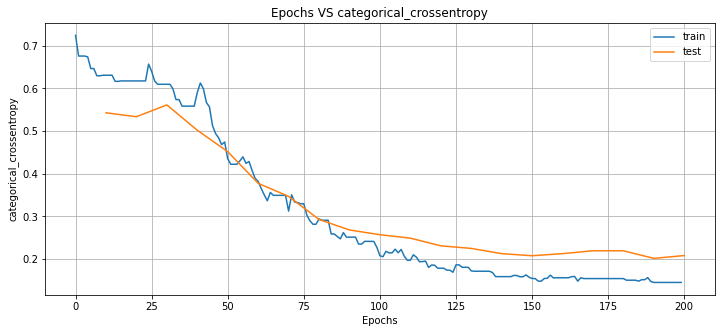

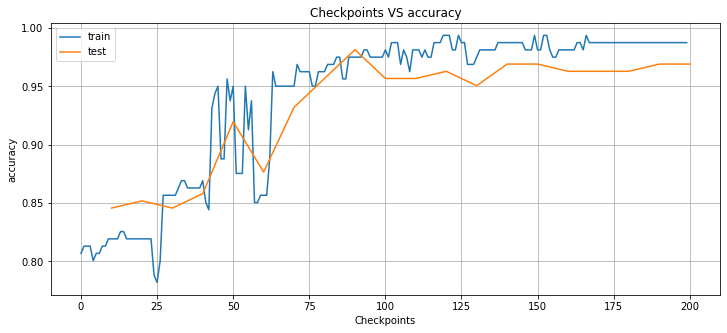

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [12]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.79285085 0.05087059 0.15627852]
[1. 0. 0.] <-> [0.8635623  0.11142009 0.02501761]
[0. 1. 0.] <-> [0.09040198 0.89848536 0.0111126 ]
[0. 1. 0.] <-> [0.55924064 0.41708642 0.02367296]
[0. 0. 1.] <-> [0.16074534 0.02555772 0.8136969 ]
[1. 0. 0.] <-> [0.9103811  0.06251094 0.02710807]
[1. 0. 0.] <-> [0.9401382  0.03977708 0.02008468]
[0. 0. 1.] <-> [0.13961785 0.02607911 0.834303  ]
[1. 0. 0.] <-> [0.952261   0.03096224 0.01677674]
[1. 0. 0.] <-> [0.9291389  0.04793031 0.02293082]
[1. 0. 0.] <-> [0.58848506 0.38695168 0.02456326]
[1. 0. 0.] <-> [0.90738624 0.07152112 0.02109262]
[1. 0. 0.] <-> [0.9621035  0.0199457  0.01795091]
[1. 0. 0.] <-> [0.92585826 0.03942176 0.03472006]
[1. 0. 0.] <-> [0.52944183 0.4386875  0.03187066]
[1. 0. 0.] <-> [0.9546193  0.02823708 0.01714369]
[0. 1. 0.] <-> [0.4132572  0.5641344  0.02260838]
[0. 0. 1.] <-> [0.46571806 0.04960093 0.48468107]
[1. 0. 0.] <-> [0.9480634  0.03003065 0.02190592]
[1. 0. 0.] <-> [0.9423883  0.03164198 0.02596973]


In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.845679012345679, 'mean_square_error': 0.3396103798835772, 'categorical_crossentropy': 0.5427120703238028, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 25, 'tn_hit': 5, 'fn_hit': 0}, 1: {'tp_hit': 1, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 15}, 2: {'tp_hit': 4, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 10}}, 'checkpoint': 10} 


{'accuracy': 0.8518518518518519, 'mean_square_error': 0.3239642062430874, 'categorical_crossentropy': 0.5335520991572628, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 24, 'tn_hit': 6, 'fn_hit': 0}, 1: {'tp_hit': 3, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 13}, 2: {'tp_hit': 3, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 11}}, 'checkpoint': 20} 


{'accuracy': 0.845679012345679, 'mean_square_error': 0.31389022584758414, 'categorical_crossentropy': 0.5612484967267072, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 25, 'tn_hit': 5, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 5, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit':

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[-1.4364341   1.8561693   1.6115775  -0.03863859 -0.04108049]
 bias: -1.5190831422805786

Neuron 1: weights:
[ 0.23873116 -1.3361546  -0.3266011   0.0234739   0.09422   ]
 bias: -0.004959046840667725

Neuron 2: weights:
[ 0.2211027   0.036288   -0.02515928  0.32216397  0.1211172 ]
 bias: -0.0773470550775528

Neuron 3: weights:
[-0.10420902  2.0095556  -0.11796873 -1.8864952  -1.0345587 ]
 bias: 1.4225032329559326

$
Layer 2
Neuron 0: weights:
[-3.          0.01812398 -0.5890302   3.        ]
 bias: 0.1238526776432991

Neuron 1: weights:
[ 3.         -1.3970934  -0.0144745  -0.02964926]
 bias: -0.6816701889038086

Neuron 2: weights:
[ 0.0497507   0.73918587  0.29627448 -3.        ]
 bias: 0.6033225655555725

$

